In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

## Data Preparation

In [2]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## (Alternatively) Select only Halal lq45 tickers using issi tickers
halal_lq45_tickers = [f for f in lq45_tickers if f in issi_tickers]

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]
halal_active_tickers_international = [f + '.JK' for f in halal_lq45_tickers]

In [3]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 135.93it/s]


In [4]:
# Do Some basic data Operations (Fill NaN, filter only certain period, and calculate Returns)
date_start = '2012-01-01'

for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Filter To Only Dates after Certain Period
    lq45_df_dict[ticker]['Date'] = pd.to_datetime(lq45_df_dict[ticker]['Date'])
    lq45_df_dict[ticker] = lq45_df_dict[ticker][lq45_df_dict[ticker]['Date'] >= date_start]
    
    # Calculate Returns
    lq45_df_dict[ticker]['return'] = lq45_df_dict[ticker]['Adj Close'].pct_change()
    
    # Reset Index After Dropped
    lq45_df_dict[ticker] = lq45_df_dict[ticker].reset_index(drop=True)

# Do the same for lq45 index data
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data['Date'] = pd.to_datetime(lq45_index_data['Date'])
lq45_index_data = lq45_index_data[lq45_index_data['Date'] >= date_start]
lq45_index_data['return'] = lq45_index_data['Adj Close'].pct_change()
lq45_index_data = lq45_index_data.reset_index(drop=True)

100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 269.45it/s]


In [5]:
# Drop Unneeded Columns and Aggregate Daily Return Data to Monthly Data
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker]['return'] += 1
    lq45_df_dict[ticker] = lq45_df_dict[ticker][['Date', 'return']]
    lq45_df_dict[ticker] = lq45_df_dict[ticker].set_index('Date').resample('MS').prod()
    lq45_df_dict[ticker]['return'] -= 1
    
# Aggregate Returns Data per ticker into each Columns
lq45_ret_df = lq45_df_dict[ticker].drop(columns='return')
for ticker in tqdm(active_tickers_international):
    lq45_ret_df[ticker] = np.nan
    lq45_ret_df[ticker] = lq45_df_dict[ticker]['return'].copy()
    
# Do the same for lq45 index data
lq45_index_data['return'] += 1
lq45_index_data = lq45_index_data[['Date', 'return']]
lq45_index_data = lq45_index_data.set_index('Date').resample('MS').prod()
lq45_index_data['return'] -= 1

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1530.71it/s]


## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [6]:
# Simple buy and hold strategy (for monthly returns data)
b_df = lq45_index_data.copy()

### Trading Strategy

Strategy by Mayank Rasu. Simple monthly portofolio restructuring based on returns. Remove `rmv_cnt` stocks with worst returns and add best performing stocks until the number is `hold_cnt`.

Note: When one stocks have two entries inside the list, can be seen as doubling down. But otherwise, can be changed.

In [7]:
# Define Strategy
def strategy(ret_df, tickers, hold_cnt=10, rmv_cnt=4):
    porto = []
    mon_ret = [0]
    for i in range(1, len(ret_df)):
        if len(porto) > 0:
            avg_porto_ret = ret_df[porto].iloc[i].mean()
            mon_ret.append(avg_porto_ret)
            rmv_porto = ret_df[porto].iloc[i].sort_values(ascending=True)[:rmv_cnt].index.values.tolist()
            porto = [p for p in porto if p not in rmv_porto]
        else:
            mon_ret.append(0)
        num_fill = hold_cnt - len(porto)
        
        # Removes all stocks with 0 returns (because of backfilled data)
        add_porto = ret_df.iloc[i][ret_df.iloc[i] != 0].sort_values(ascending=True)[:num_fill].index.values.tolist()
        porto = porto + add_porto
    
    porto_ret_df = pd.DataFrame(index = ret_df.index)
    porto_ret_df['return'] = np.array(mon_ret)
    
    return porto_ret_df

In [8]:
# Run Strategy
s_df = strategy(lq45_ret_df, active_tickers_international)

## Evaluation

### Calculate Metrics for Strategy

In [9]:
# Prepare for Metric Calculation
s_ret = s_df['return'].astype(float)
b_ret = b_df['return'].astype(float)

# Calculate Metrics
qs.reports.metrics(returns=s_ret, benchmark=b_ret, rf=0.025, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2012-01-01  2012-01-01
End Period          2022-06-01  2022-06-01
Risk-Free Rate      2.5%        2.5%
Time in Market      99.0%       100.0%

Cumulative Return   221.36%     54.5%
CAGR﹪              11.85%      4.26%

Sharpe              2.59        1.53
Prob. Sharpe Ratio  93.92%      80.57%
Sortino             4.24        2.06
Sortino/√2          3.0         1.45
Omega               1.54        1.54

Max Drawdown        -51.84%     -37.5%
Longest DD Days     1034        1581

Gain/Pain Ratio     0.55        0.3
Gain/Pain (1M)      0.55        0.3

Payoff Ratio        1.18        0.81
Profit Factor       1.55        1.3
Common Sense Ratio  2.02        0.94
CPC Index           1.0         0.64
Tail Ratio          1.3         0.72
Outlier Win Ratio   2.32        4.33
Outlier Loss Ratio  2.45        3.05

MTD                 -1.0%       -1.93%
3M                  7.44%       5.16%
6

### Plot Relevant Visualizations

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


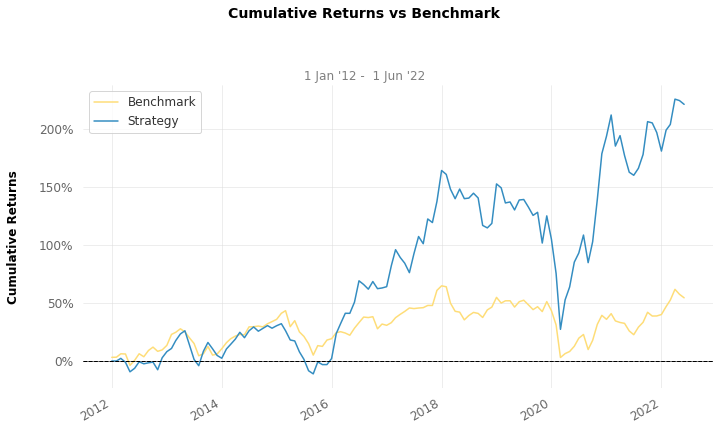

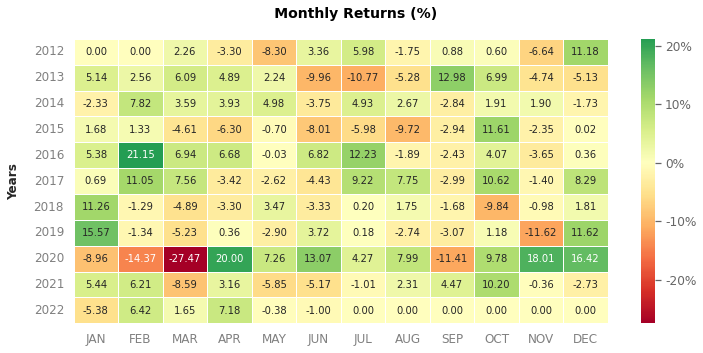

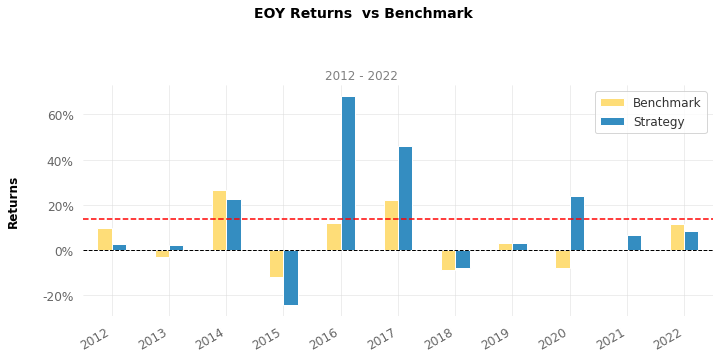

In [10]:
# Returns Visualization
qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)
qs.plots.yearly_returns(s_ret, b_ret)

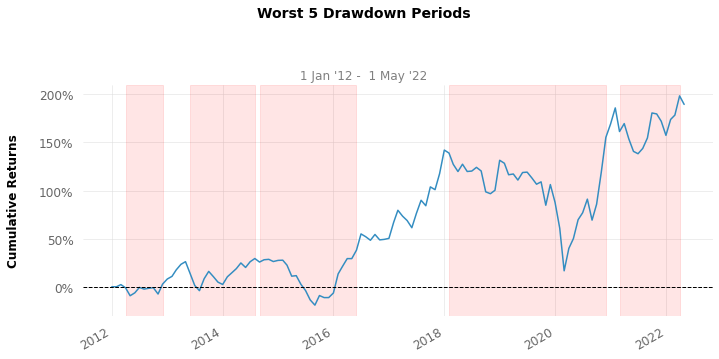

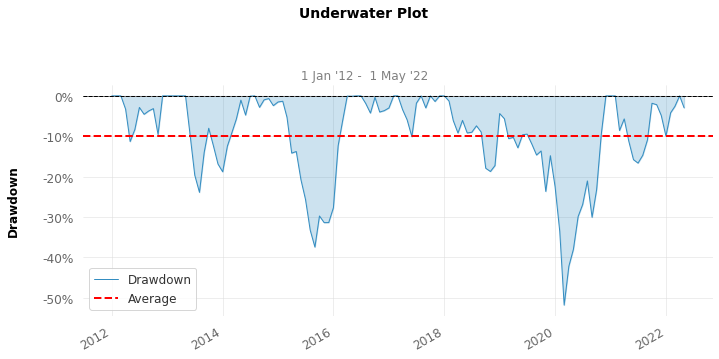

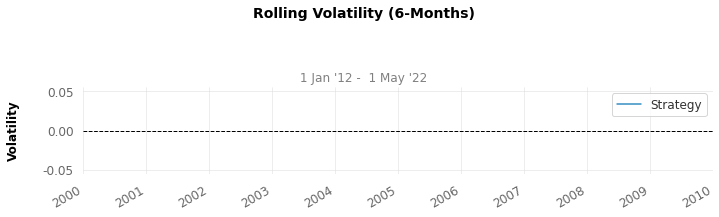

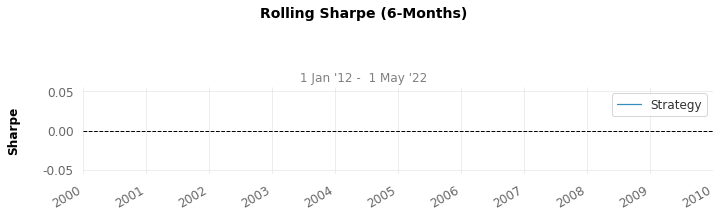

In [66]:
# Risk Visualization
qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)